In [256]:
from functools import partial
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [258]:
images_dir = 'IMG'
masks_dir = 'Mask'

dirname, _, filenames = next(os.walk(images_dir))

In [260]:
@tf.function
def load_img_with_mask(image_path, images_dir: str = 'IMG', masks_dir: str = 'Mask',images_extension: str = 'png', masks_extension: str = 'png') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=3, expand_animations = False)
    return (image, mask)

In [417]:
def count_images_in_dir(images_dir: str) -> int:
    _, _, filenames = next(os.walk(images_dir))
    return len(filenames)

# Пример использования
images_dir = 'IMG'
masks_dir = 'Mask'

num_images = count_images_in_dir(images_dir)
print(f"Количество фотографий в директории {images_dir}: {num_images}")
num_images = count_images_in_dir(masks_dir)
print(f"Количество фотографий в директории {masks_dir}: {num_images}")


Количество фотографий в директории IMG: 299
Количество фотографий в директории Mask: 299


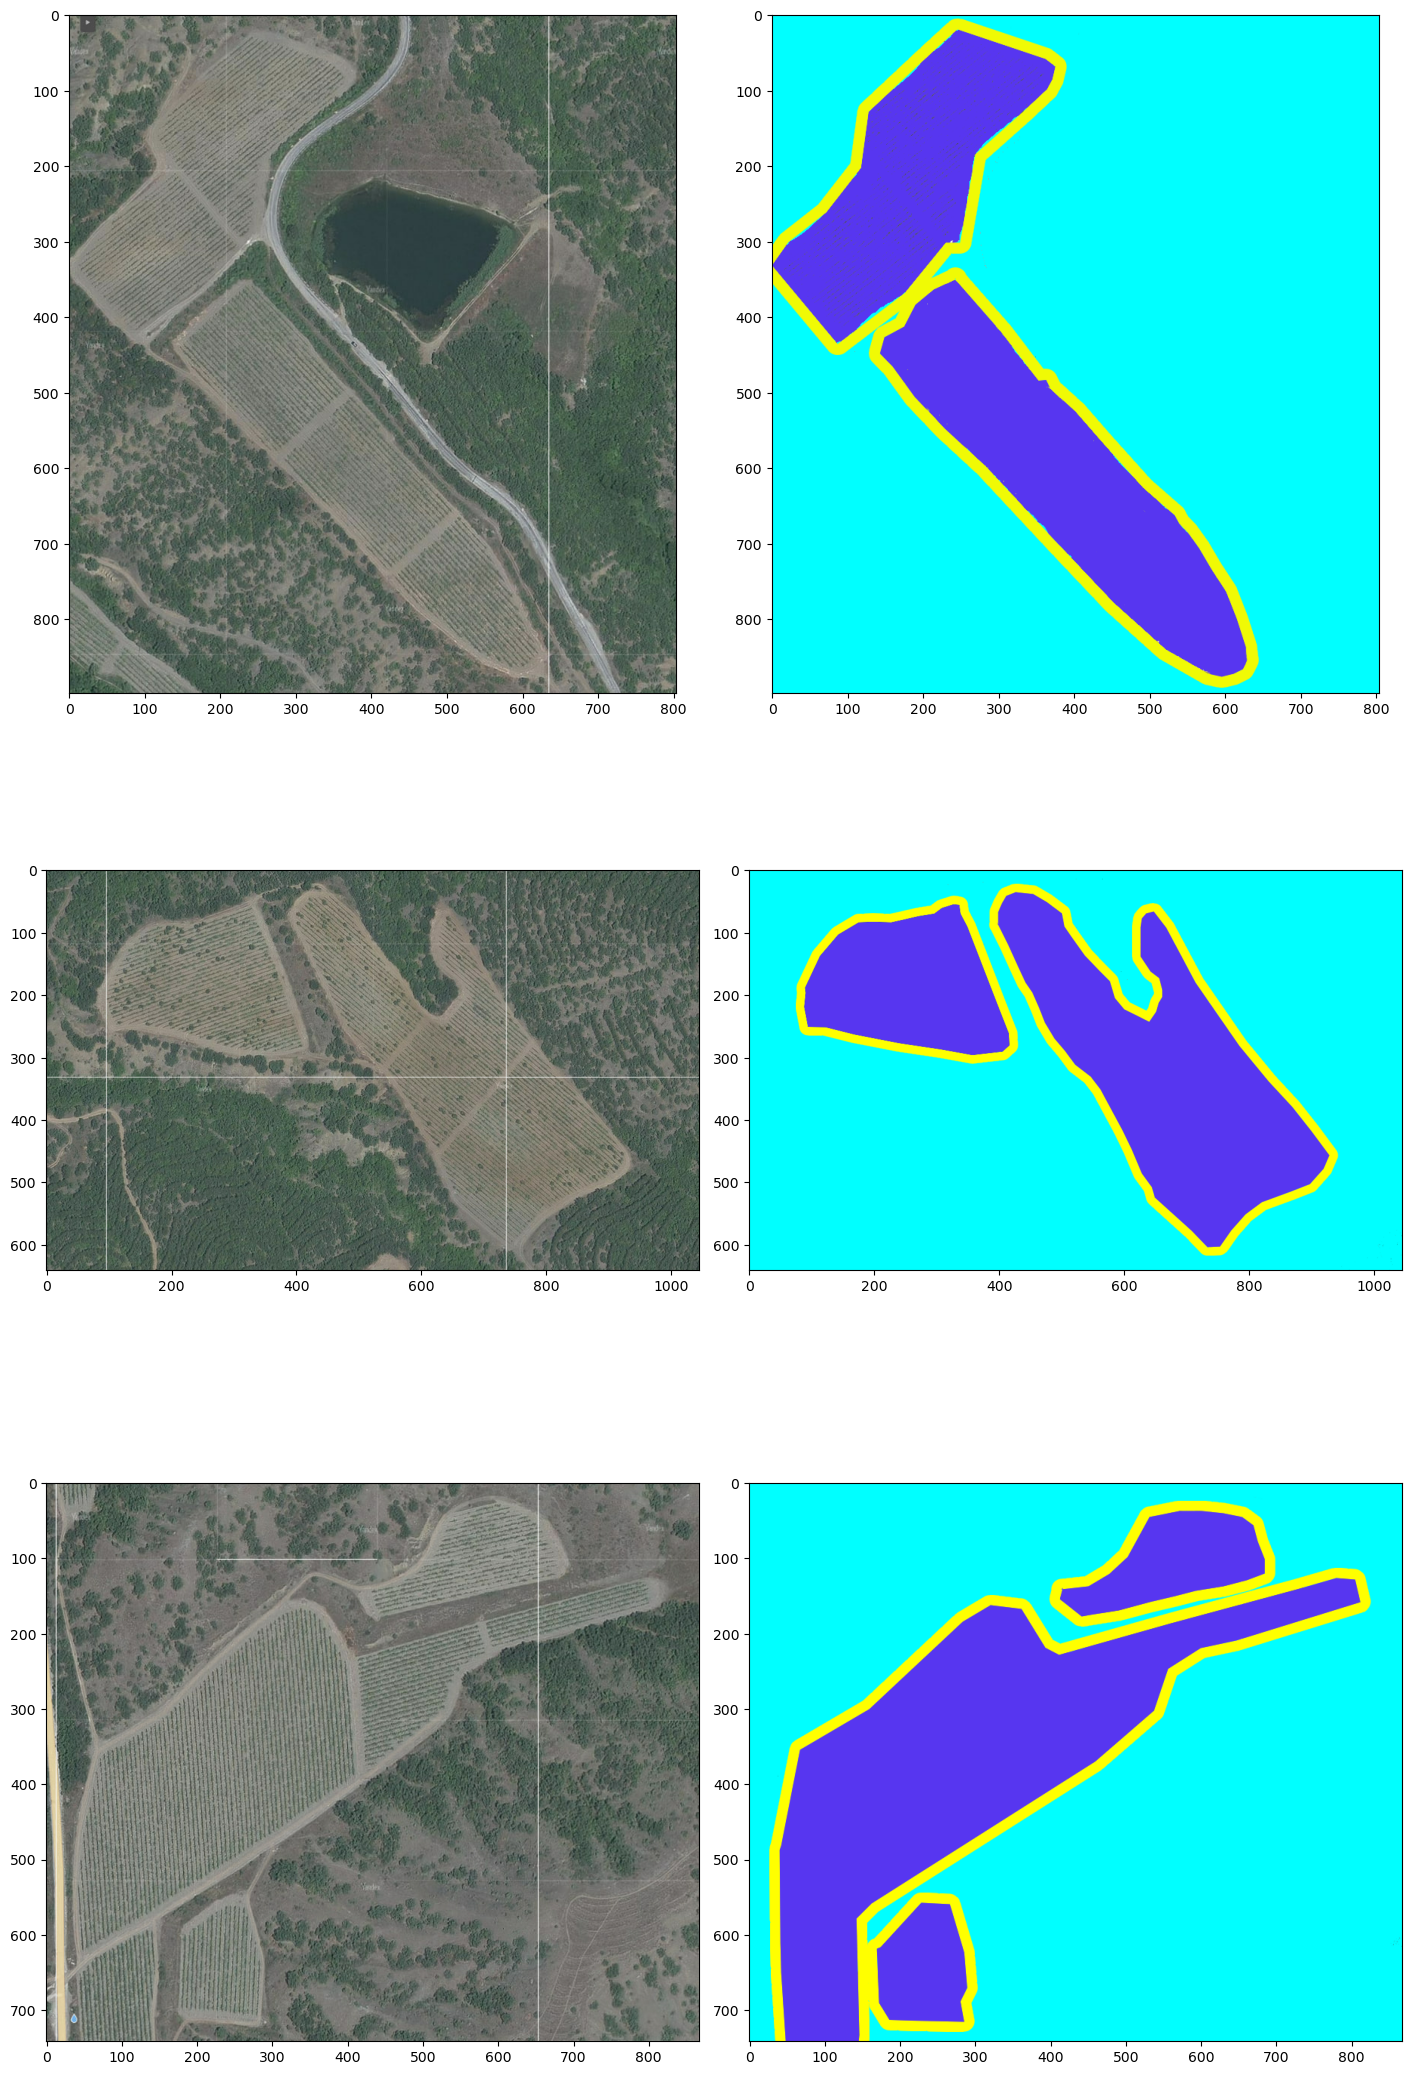

In [264]:
%matplotlib inline
n_examples = 3
examples = [load_img_with_mask(os.path.join(images_dir, filenames[i])) for i in range(n_examples)]

fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)

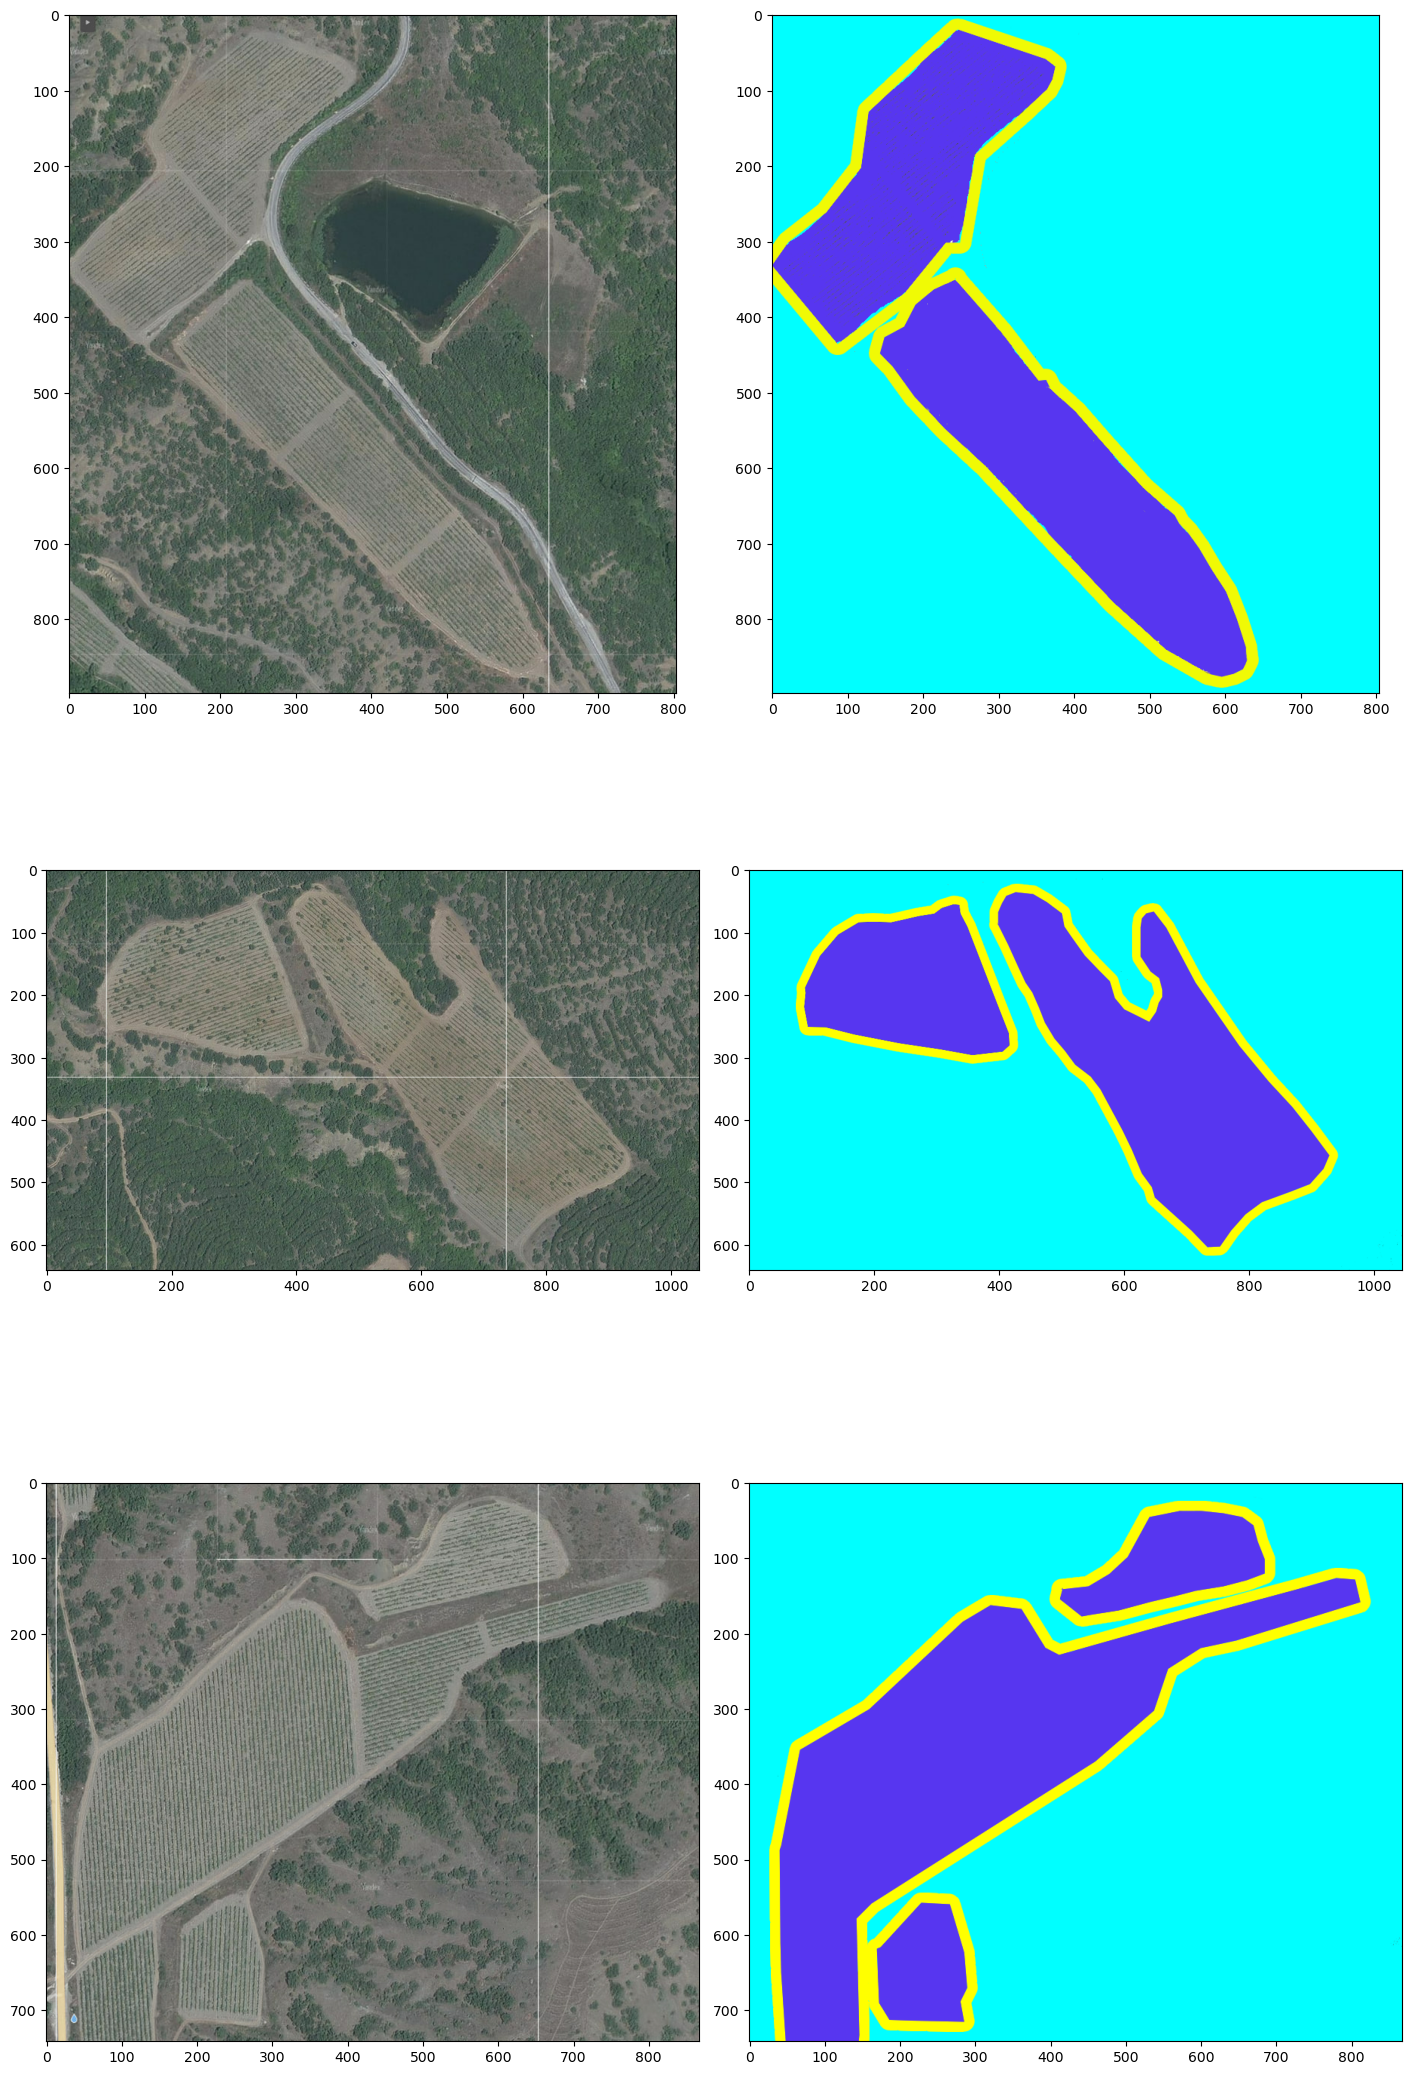

In [266]:
fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)

In [380]:
@tf.function
def resize_images(images, masks, max_image_size=512):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

@tf.function
def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    
    # Вычисляем целевые размеры
    target_height = tf.math.ceil(tf.cast(height, tf.float32) / pad_mul) * pad_mul
    target_width = tf.math.ceil(tf.cast(width, tf.float32) / pad_mul) * pad_mul
    
    # Убеждаемся, что целевые размеры не меньше исходных
    target_height = tf.maximum(target_height, tf.cast(height, tf.float32))
    target_width = tf.maximum(target_width, tf.cast(width, tf.float32))
    
    # Преобразуем обратно в int32
    target_height = tf.cast(target_height, tf.int32)
    target_width = tf.cast(target_width, tf.int32)
    
    # Вычисляем отступы
    pad_height = target_height - height
    pad_width = target_width - width
    
    # Применяем паддинг
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width)
    
    return images, masks
    """
@tf.function
def resize_and_pad_images(img, mask, target_size=512):
    shape = tf.shape(img)
    height, width = shape[-3], shape[-2]
    
    # Вычисляем соотношение сторон
    aspect_ratio = tf.cast(width, tf.float32) / tf.cast(height, tf.float32)
    
    # Определяем новые размеры
    if aspect_ratio > 1:
        new_width = target_size
        new_height = tf.cast(target_size / aspect_ratio, tf.int32)
    else:
        new_height = target_size
        new_width = tf.cast(target_size * aspect_ratio, tf.int32)
    
    # Изменяем размер изображения и маски
    img = tf.image.resize(img, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)
    mask = tf.image.resize(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Добавляем паддинг до целевого размера
    img = tf.image.pad_to_bounding_box(img, (target_size - new_height) // 2, (target_size - new_width) // 2, target_size, target_size)
    mask = tf.image.pad_to_bounding_box(mask, (target_size - new_height) // 2, (target_size - new_width) // 2, target_size, target_size)
    
    return img, mask"""

In [424]:
batch_size = 4
test_set_size = 5
validation_set_size = 100

dataset = tf.data.Dataset.list_files(images_dir + '/*.png', seed=42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask, max_image_size=512))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(5)


validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(5)

In [426]:
# Подсчет количества изображений в тренировочном наборе # Размер батча
num_batches = tf.data.experimental.cardinality(train_dataset).numpy()
total_images = num_batches * batch_size
print(f"Общее количество изображений в тренировочном наборе: {total_images}")



Общее количество изображений в тренировочном наборе: 776


In [428]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
    PartialConv = partial(keras.layers.Conv2D,
     activation=hidden_activation,
     kernel_initializer=initializer,      
     padding='same')
    
    # pooling
    model_input = keras.layers.Input(shape=(None, None, 3))
    enc_cov_1 = PartialConv(32, 3)(model_input)
    enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
    enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
    
    enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
    enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
    enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
    enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
    enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
    enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
    # Center
    center_cov = PartialConv(256, 3)(enc_pool_3)
    center_cov = PartialConv(256, 3)(center_cov)
    
    # upsampling
    upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
    dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
    dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
    dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
    dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
    upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
    dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
    dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
    dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
    dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
    upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
    dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
    dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
    dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
    dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)
    
    output = keras.layers.Conv2D(3, 1, activation=output_activation)(dec_conv_3)
    
    return tf.keras.Model(inputs=model_input, outputs=output)

In [430]:
def check_dataset_shapes(dataset):
    shapes = set()
    for images, masks in dataset.take(8):  # Проверяем первые 10 батчей
        shapes.add((images.shape[1], images.shape[2]))
    print(f"Unique shapes in dataset: {shapes}")

# Проверяем датасеты
print("Train dataset:")
check_dataset_shapes(train_dataset)
print("Validation dataset:")
check_dataset_shapes(validation_dataset)
print("Test dataset:")
check_dataset_shapes(test_dataset)

Train dataset:
Unique shapes in dataset: {(336, 448), (256, 432), (240, 416), (288, 416), (416, 304), (384, 352), (464, 496)}
Validation dataset:
Unique shapes in dataset: {(448, 336), (448, 496), (416, 304), (288, 432), (464, 496), (432, 224), (304, 400)}
Test dataset:
Unique shapes in dataset: {(448, 336), (384, 240), (384, 304), (336, 336), (432, 240)}


In [431]:
model = get_unet()

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

In [433]:
SPE= len(images_dir)//batch_size

In [436]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 100
history = model.fit(train_dataset, validation_data=validation_dataset, steps_per_epoch=SPE, epochs=epochs, callbacks=[early_stopping, lr_reduce])

Epoch 1/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 107s 513ms/step - accuracy: 0.4249 - loss: 0.4303 - val_accuracy: 0.4129 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 102s 527ms/step - accuracy: 0.4195 - loss: 0.3514 - val_accuracy: 0.3721 - val_loss: 0.3559 - learning_rate: 0.0010
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 95s 489ms/step - accuracy: 0.3961 - loss: 0.3529 - val_accuracy: 0.3794 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 4/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 94s 483ms/step - accuracy: 0.3973 - loss: 0.3287 - val_accuracy: 0.3628 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 5/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 95s 490ms/step - accuracy: 0.3730 - loss: 0.3169 - val_accuracy: 0.4087 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 6/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 95s 487ms/step - accuracy: 0.4145 - loss: 0.3095 - val_accuracy: 0.3936 - val_loss: 0.2977 - learning_rate: 0.0010
Epoch 7/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 93s 479ms/step - accu

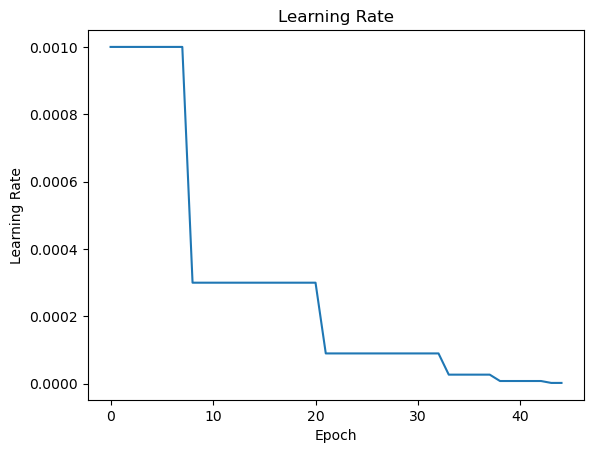

In [442]:
plt.plot(history.history['learning_rate'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


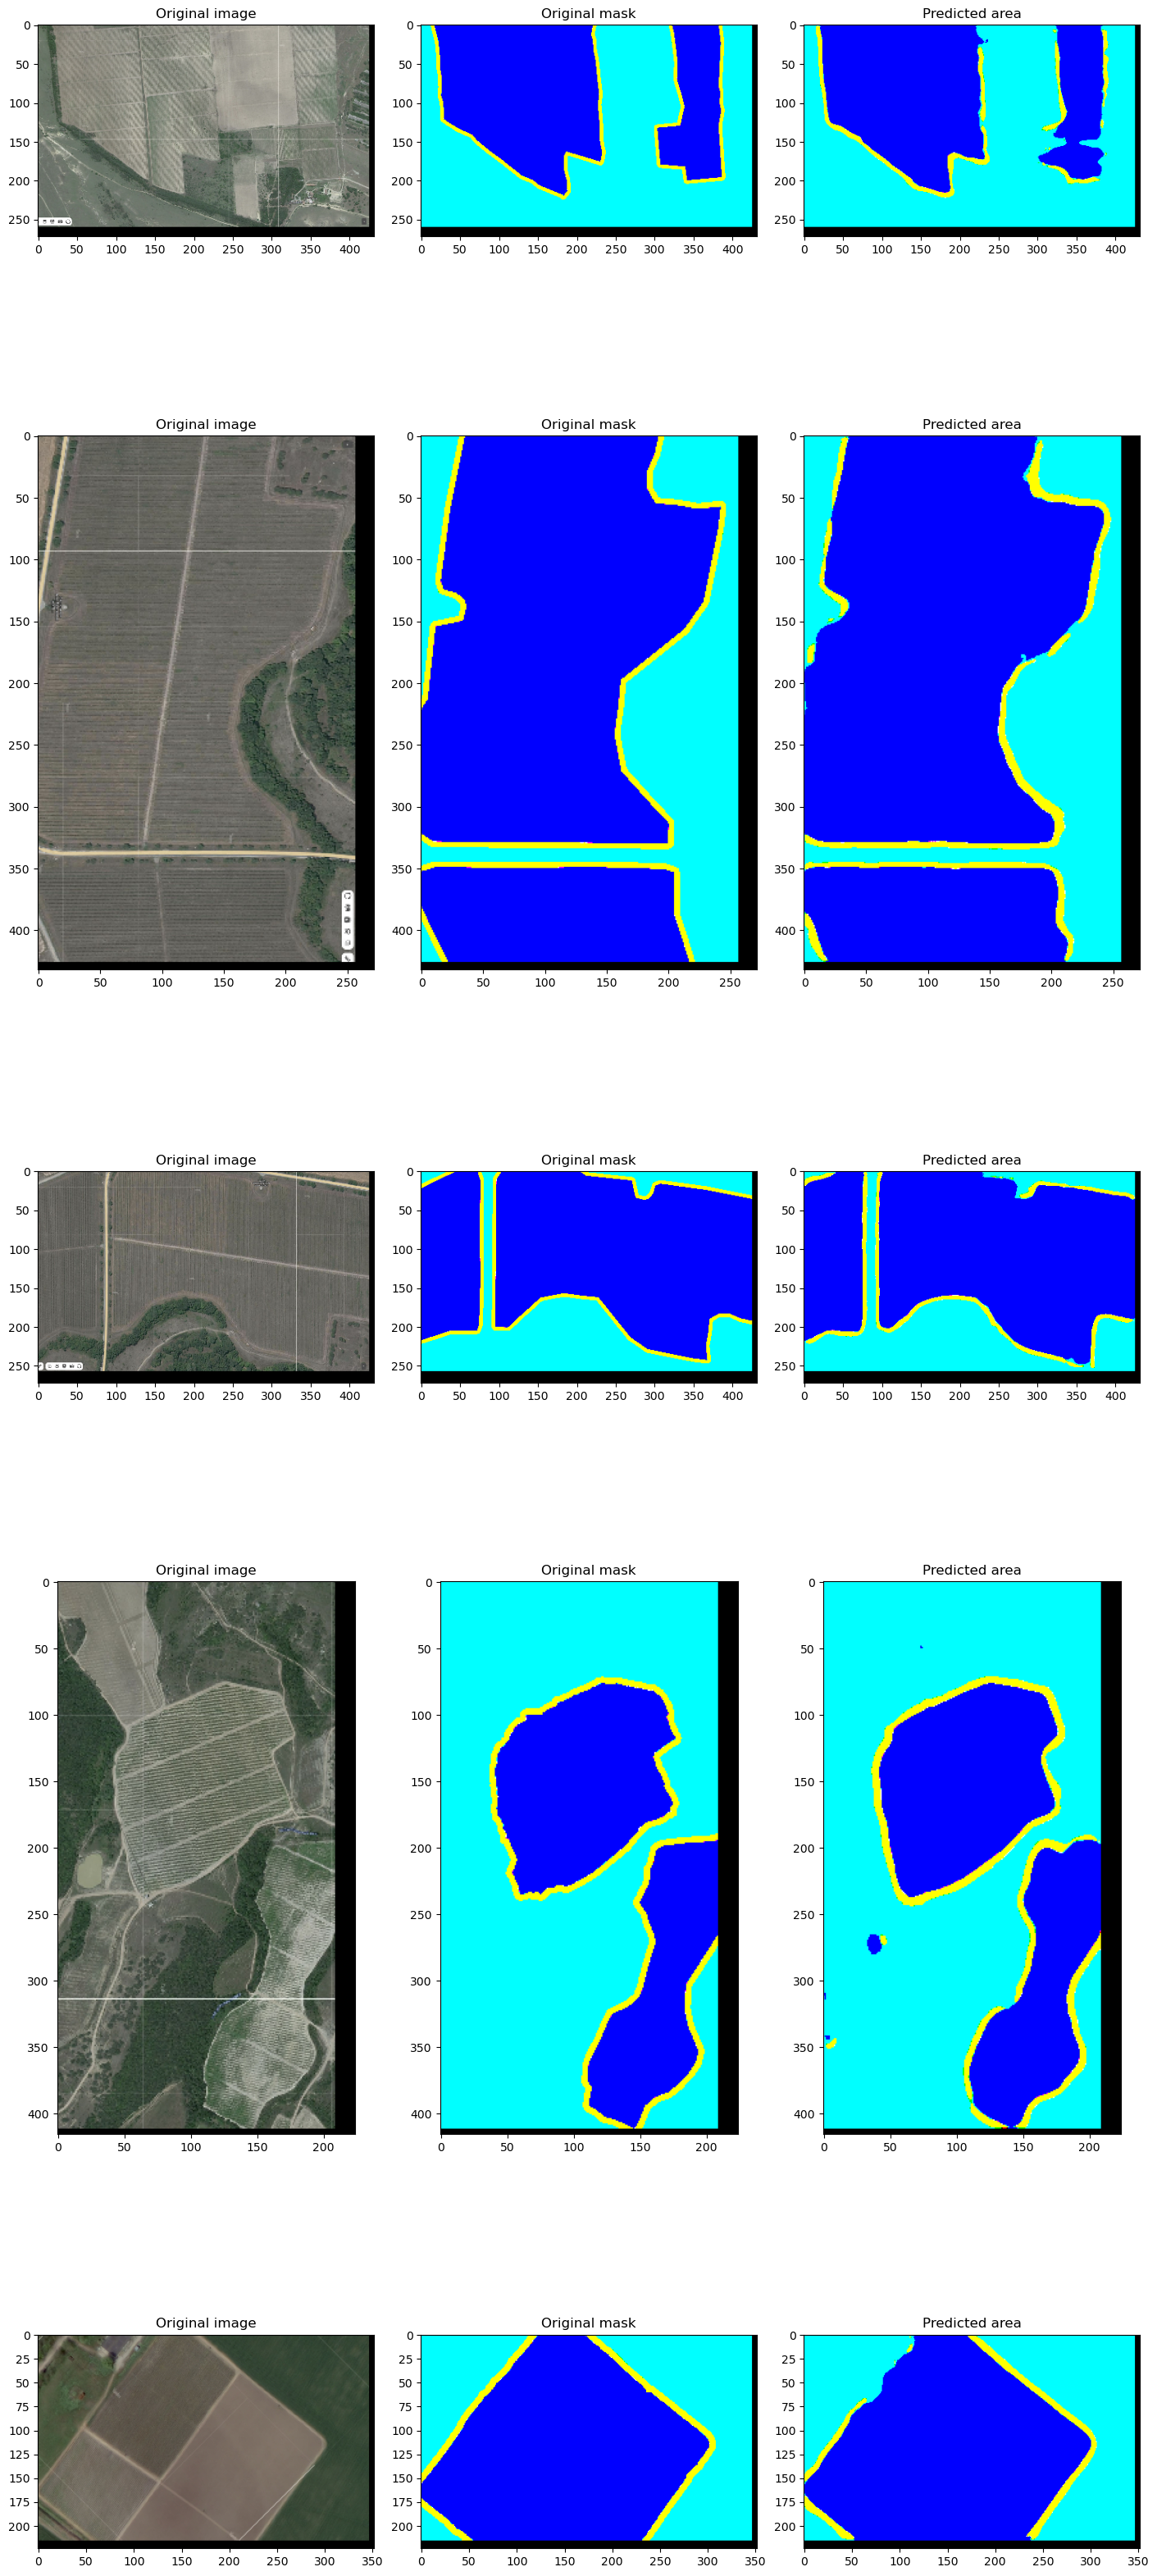

In [446]:
n_examples = 5

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(y_true[0])
    ax[2].set_title('Predicted area')
    ax[2].imshow(prediction)